In [103]:
import sys

path_src = '../../src'
sys.path.append(path_src)
import importlib
import SpatialAnalysis as SpAn
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pathlib, importlib
import numpy as np
path_src = '../../tysserand2/'
from tqdm import tqdm


## Preprocessing: 
1. Select random 60 samples (50% each group)

In [104]:
resampling = False
if resampling:
    clinical_path = pathlib.Path('../../data/publicdatasets/BreastCancer_Danenberg_2022/IMCClinical_Danenberg_2022.csv')
    clinical = pd.read_csv(clinical_path)

    sample_size = 30
    clinical_subsample = clinical.loc[clinical['Grade']==2,:].groupby('DeathBreast').apply(lambda x: x.sample(n=sample_size)).reset_index(drop=True)
    clinical_subsample.sample()
    clinical_subsample['yearsToStatus'].hist()
    clinical_subsample.to_csv('../../data/publicdatasets/BreastCancer_Danenberg_2022/clinical_subsample.csv')
else:
    clinical_subsample = pd.read_csv('../../data/publicdatasets/BreastCancer_Danenberg_2022/clinical_subsample.csv',index_col=0)

display(clinical_subsample.sample())
selected_samples = clinical_subsample['metabric_id'].values

,metabric_id,ERStatus,LymphNodesOrdinal,sizeOrdinal,Grade,ERBB2_pos,yearsToStatus,DeathBreast,isValidation,PAM50,IntClust
31,MB-3085,pos,0,20-50mm,2.0,False,17.327858,1,True,Normal-like,IntClust 4+


Cell coordiantes and markers

In [110]:
Cells = pd.read_parquet('../../../../Data/IMC_Breast_cancer_Danenberg_2022/SingleCells.parquet')
print(f"Total number of cells: {Cells.shape[0]}")
T = Cells.shape[0]
Cells = Cells[Cells['metabric_id'].isin(selected_samples)]
print(f"Selected cells: {Cells.shape[0]} ({Cells.shape[0]/T:.2%})")
n = Cells['metabric_id'].unique().shape[0]
print(f'Total number of samples is {n}')
Cells.sample()


Total number of cells: 1123466
Selected cells: 78989 (7.03%)
Total number of samples is 60


,ImageNumber,ObjectNumber,metabric_id,cellPhenotype,is_epithelial,is_tumour,is_normal,is_dcis,is_interface,is_perivascular,...,CD31-vWF,CXCL12,HLA-ABC,panCK,c-Caspase3,DNA1,DNA2,Location_Center_X,Location_Center_Y,AreaShape_Area
814797,661,1101,MB-3035,CK^{+} CXCL12^{+},1,1,0,0,0,0,...,0.319058,0.54528,0.685952,16.136242,0.082839,34.020992,64.102456,376.430894,441.943089,123


## 1. Compute Networks KNN (K = 20)

In [112]:
k_value = 30
connections_all = []
importlib.reload(SpAn)
for sample in tqdm(selected_samples):
    CellSample = Cells.loc[Cells['metabric_id']==sample,:]
    points = CellSample[['Location_Center_X','Location_Center_Y']]
    types = CellSample['cellPhenotype']
    edges, rank, distances = SpAn.knn_edges(points, k = k_value, return_rank = 1, return_distances = 1)
    connections = pd.DataFrame(edges, columns=['source','target'])
    connections['rank'] = rank
    connections['distances'] = distances
    connections['sample'] = sample
    connections_all.append(connections)

connections_all = pd.concat(connections_all)

Script loaded!


100%|██████████| 60/60 [02:02<00:00,  2.03s/it]


<Axes: xlabel='rank', ylabel='distances'>

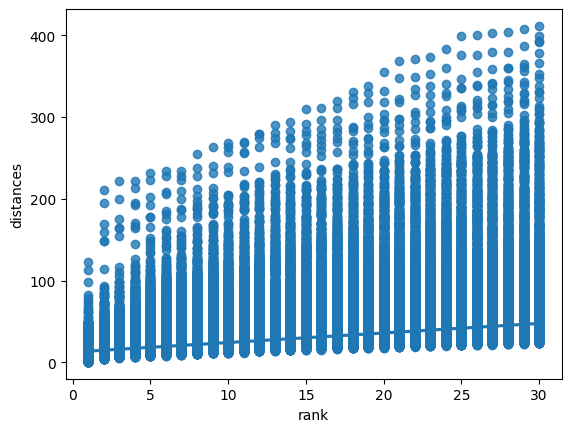

In [113]:
sns.regplot(data = connections_all, x = 'rank', y = 'distances', )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


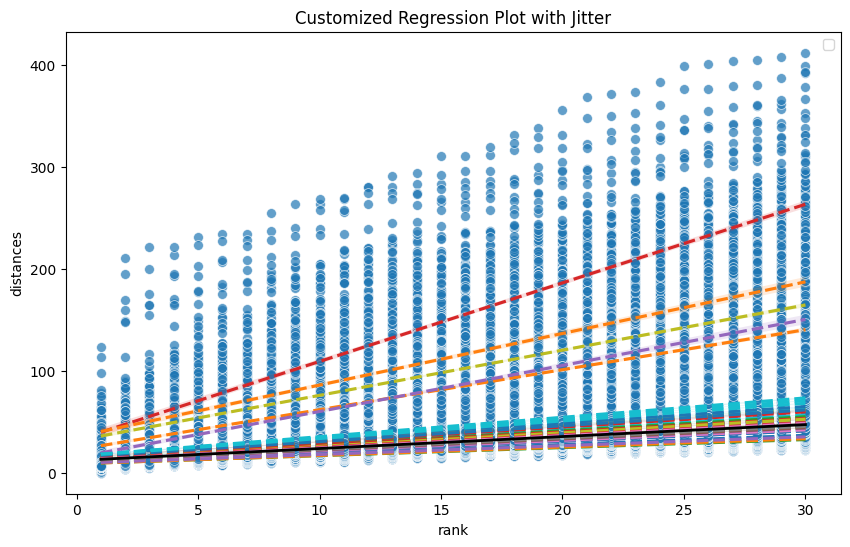

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)

# Create a scatter plot with jitter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=connections_all, x='rank', y='distances', s=5, alpha=0.5)

# Plot regression lines for each sample
for sample in connections_all['sample'].unique():
    sns.regplot(data=connections_all[connections_all['sample'] == sample], color='gray', alpha=0.5, 
                x='rank', y='distances', scatter=False, line_kws={'linestyle': '--'})

# Plot a thicker regression line for all samples
sns.regplot(data=connections_all, x='rank', y='distances', scatter=False, color='red', 
            line_kws={'linewidth': 2, 'label': 'Overall Regression'})

# Customize the legend
plt.legend()
plt.title('Customized Regression Plot with Jitter')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


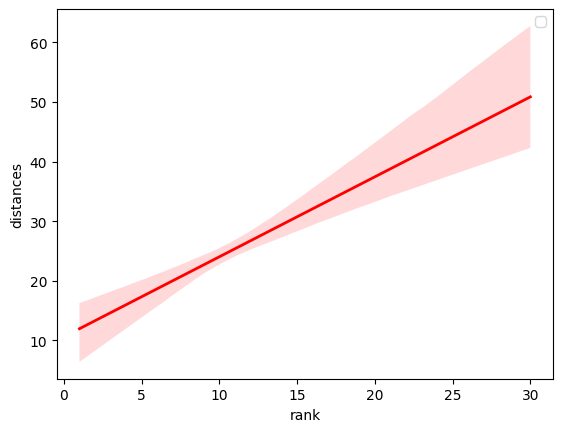

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)

# # Create a scatter plot with jitter
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=connections_all, x='rank', y='distances', s=5, alpha=0.5)

# # Plot regression lines for each sample
# for sample in connections_all['sample'].unique():
#     sns.regplot(data=connections_all[connections_all['sample'] == sample], color='gray', 
#                 x='rank', y='distances', scatter=False, line_kws={'linewidth': .2,'linestyle': '--'})

# Plot a thicker regression line for all samples
sns.regplot(data=connections_all.sample(100), x='rank', y='distances', scatter=False, color='red', 
            line_kws={'linewidth': 2, 'label': 'Overall Regression'})

# Customize the legend
plt.legend()
plt.show()


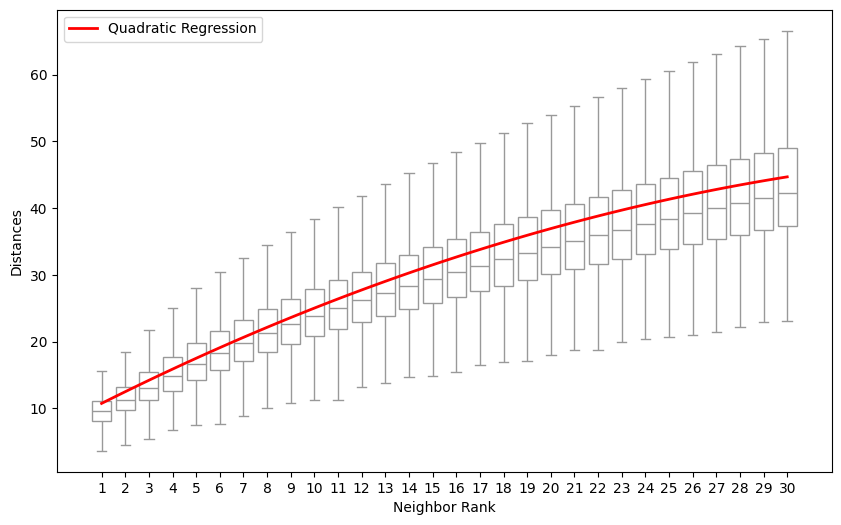

In [142]:
# Assuming connections_all is your DataFrame and it has 'rank' and 'distances' columns
x = connections_all['rank']
y = connections_all['distances']

# Fit a quadratic regression model
coefficients = np.polyfit(x, y, 2)  # 2 is the degree of the polynomial
poly = np.poly1d(coefficients)

# Create the regression line values
x_reg = np.linspace(x.min(), x.max(), 100)
y_reg = poly(x_reg)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=connections_all, x='rank', y='distances', color='white', showfliers=False)
plt.plot(x_reg-1, y_reg, color='red', linewidth=2, label='Quadratic Regression')
plt.legend()
plt.xlabel('Neighbor Rank')
plt.ylabel('Distances')
# plt.title('Non-linear Regression Plot with Boxplots (Outliers Removed)')
plt.show()